### This is a step by step walk through a Pytorch implementation of a gated convolutional neural network (GCNN) from Dauphin et al.'s 2017 paper. I use the wikitext-2 dataset.
### 

# Download and preprocess data

In [83]:
#Install pytorch and fastai (see https://docs.fast.ai/)
!conda update conda --yes
!conda install -c pytorch pytorch-nightly cuda90 --yes
!conda install -c fastai torchvision-nightly --yes
!conda install -c fastai fastai --yes
!conda install -c anaconda jupyter unzip cython cupy seaborn --yes

    100% |████████████████████████████████| 307kB 28.6MB/s 
    100% |████████████████████████████████| 71kB 23.7MB/s 
    100% |████████████████████████████████| 133kB 27.6MB/s 
    100% |████████████████████████████████| 552kB 22.7MB/s 
  Running setup.py bdist_wheel for conda ... done
  Stored in directory: /root/.cache/pip/wheels/a3/50/79/302742d53e2231ec545cb3791abfdd24de234021ed8e0588a0
  Running setup.py bdist_wheel for pycosat ... done
  Stored in directory: /root/.cache/pip/wheels/c4/67/ff/5570304e45814eccef48a3c69c3af25d0456ed3a34eddbbe38
Successfully built conda pycosat
menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 3.0.2 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.4.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'p

In [26]:
from fastai import *
from fastai.text import * 

import torch.utils.data as data_utils
from torch.utils.data.dataset import Dataset
from torch.utils.data.sampler import Sampler
from torch.autograd import Variable

import time
import importlib
import seaborn as sns

from GCNN_textfuncs import *

In [2]:
DATAPATH = Path('/floyd/home/ed-triage/data/')

In [3]:
sns.set() #set graph formatting to seaborn

In [4]:
#download wikitext-2 dataset and GloVe embeddings
#!wget https://s3.amazonaws.com/fast-ai-nlp/wikitext-2.tgz -P /data
#!tar xzf /data/wikitext-2.tgz -C /data
#!mv /data/wikitext-2/ /data/GCNN/
#!wget http://nlp.stanford.edu/data/glove.6B.zip -P /data/GCNN/
#!unzip /data/GCNN/glove.6B.zip -d /data/GCNN/

In [4]:
#Do some preprocessing of the data:

#put data into df's w/ columns for 'labels' and 'text'
df_trn = pd.read_csv(DATAPATH/'train.csv',header=None,names=['text'])
df_test = pd.read_csv(DATAPATH/'test.csv',header=None,names=['text'])
df_trn['labels']=0
df_test['labels']=0
df_trn=df_trn[['labels','text']]
df_test=df_test[['labels','text']]

#split data into paragraphs, then remove paragraphs <10 or >300 words
trn_paragraphs=[]
for docnum in range(len(df_trn)):
    trn_paragraphs.extend([x for x in df_trn.iloc[docnum].text.split('\n')])
trn_paragraphs.sort(key=len)
trn_paragraphs=[par for par in trn_paragraphs if (len(par.split(' '))<300 and len(par.split(' '))>10)]#remove paragraphs >300 and <10 words
trn_paragraphs=[par+'xxeos ' for par in trn_paragraphs] #add EOS token at end of each paragraph

test_paragraphs=[]
for docnum in range(len(df_test)):
    test_paragraphs.extend([x for x in df_test.iloc[docnum].text.split('\n')])
test_paragraphs.sort(key=len)
test_paragraphs=[par for par in test_paragraphs if (len(par.split(' '))<300 and len(par.split(' '))>10)]#remove paragraphs >300 and <10 words
test_paragraphs=[par+'xxeos ' for par in test_paragraphs] #add EOS token at end of each paragraph

#put data into csv's
df_trn_par = pd.DataFrame({'text':trn_paragraphs})
df_test_par = pd.DataFrame({'text':test_paragraphs})

df_trn_par['labels']=0
df_test_par['labels']=0
df_trn_par=df_trn_par[['labels','text']]
df_test_par=df_test_par[['labels','text']]

df_trn_par.to_csv(DATAPATH/'train_proc_par2.csv', header=False, index=False)
df_test_par.to_csv(DATAPATH/'test_proc_par2.csv', header=False, index=False)


# Create modeler class

In [5]:
class modeler():
    def __init__(self,trn_dl,val_dl,module,modelvals=None):
        self.trn_dl, self.val_dl, self.module = trn_dl, val_dl, module
        self.modelvals=modelvals
        self.model=self.module.cuda()
    def model_fit(self):
        samp_n=self.modelvals['samp_n']#the number of iterations in an epoch
        starttime=time.time()
        train_loss_list=[]; val_loss_list=[]
        for epoch in range(0, self.modelvals['epochs']):
            pbar=0#progressbar
            for batch_idx, (data, target) in enumerate(self.trn_dl):
                
                #GRAB MINIBATCH OF INPUTS AND TARGETS, SET OPTIMIZER
                data = Variable(data)
                pbar+=self.modelvals['bs'] #how many iterations have we done in the epoch so far
                if self.modelvals['opttype']=='sgd':
                    self.optimizer = optim.SGD(self.model.parameters(), lr=self.modelvals['lr'], 
                                       momentum=self.modelvals['mom'], weight_decay=self.modelvals['wd'],
                                              nesterov=self.modelvals['nesterov'])
                elif self.modelvals['opttype']=='adam':
                    self.optimizer = optim.Adam(self.model.parameters(), lr=self.modelvals['lr'], 
                                        betas=(self.modelvals['mom'], 0.999))
                self.optimizer.zero_grad()
                
                #FORWARD PASS
                output = self.model(data)
                
                #CALCULATE AND BACKPROP THE LOSS
                loss= output.loss
                loss.backward()
                if self.modelvals['grad_clip']!=0: #gradient clipping
                    torch.nn.utils.clip_grad_value_(self.model.parameters(), self.modelvals['grad_clip'])
                    
                #UPDATE THE WEIGHTS
                self.optimizer.step()
                
                #PRINT OUT TRAINING UPDATES
                train_loss_list.append([epoch,pbar+epoch*samp_n,loss.data.item(),self.modelvals['lr']])
                if batch_idx % 100 == 0:
                    elapsed_time=time.time()-starttime
                    train_update_format_string = 'Train Epoch: {}'
                    train_update_format_string += '\tTotal_its: {:.2f}M [{:.2f}M/{:.2f}M]'
                    train_update_format_string += '\tPercdone: {:.2f}'
                    train_update_format_string += '\tLoss: {:.4f}'
                    train_update_format_string += '\tTime: {:.2f}'
                    train_update_format_string += '\tLR: {:.4f}'
                    train_update_string=train_update_format_string.format(
                            epoch,
                            (pbar + epoch * samp_n) / 1000000, pbar / 1000000, samp_n / 1000000,
                            pbar / samp_n,
                            loss.data.item(),
                            elapsed_time / 60,
                            self.modelvals['lr'])
                    print(train_update_string)
            final_train_loss=loss.data.item()
            
            #NOW TEST VALIDATION SET
            val_loss=[]
            self.model.eval() #important to set to eval mode for testing, so that eg batchnorm and dropout aren't used
            for batch_idx, (data, target) in enumerate(self.val_dl):
                data = Variable(data)
                self.optimizer.zero_grad()
                #ONLY NEED FORWARD PASS... NO BACKPROP
                output = self.model(data)
                loss= output.loss
                output=output.output
                val_loss.append(loss.data.item())
            self.model.train() #set back to training mode
            ave_val_loss=sum(val_loss) / len(val_loss)
            val_update_string='Validation Loss: {:.4f}\tPerp: {:.4f}'.format(
                ave_val_loss,np.exp(ave_val_loss))
            print(val_update_string)
            val_loss_list.append([epoch,ave_val_loss, np.exp(ave_val_loss),elapsed_time/60])
        self.modelvals['val_loss_list']=val_loss_list
        self.modelvals['train_loss_list']=train_loss_list
        print('The end! {:.2f} minutes'.format((time.time()-starttime)/60))

# Set hyperparameters and build embeddings

In [6]:
#set hyperparameters
bs=50 #batch-size
emb_sz=300 #size of the embedding matrix
nl=4 #number of layers
nh=600 #number hidden units
lr=1 #learning rate
mom=.95 #momentum
wd=5e-5 #weight-decay. Only has effect if opttype==sgd
epochs=50
nesterov=True #Nesterov momentum. only has effect if opttype==sgd
grad_clip=0.07 #gradient clipping value. Set to 0 for no effect. See nn.utils.clip_grad_value_
opttype='sgd' #adam, sgd
k=4 #kernel_width
downbot=20# in the bottleneck layers, how much to decrease channel depth?


In [31]:
#Use fast.ai to create a TextLMDataBunch object. See http://docs.fast.ai/text.data.html#class-textlmdatabunch
#This tokenizes and numericalizes the data
data_lm = TextLMDataBunch.from_csv(path=DATAPATH, csv_name='train_proc_par2.csv', test='test_proc_par2.csv')
itos=data_lm.train_ds.vocab.itos# the vocab
vs=len(itos)# vs is the length of the vocab

#Grab the numericalized data from the TextLMDataBunch dataset, then construct new custom dataset using LMDataset_GCNN
trn_tokens=[data_lm.train_ds[i][0].data for i in range(len(data_lm.train_ds))]
traindataset=LMDataset_GCNN(trn_tokens)
valid_tokens=[data_lm.valid_ds[i][0].data for i in range(len(data_lm.valid_ds))]
validdataset=LMDataset_GCNN(valid_tokens)

#Create data loaders for training and validation sets
trn_samp=SortishSampler_GCNN(data_length=len(traindataset),key=lambda x:len(traindataset[x][0]), bs=bs)
val_samp=SortSampler_GCNN(validdataset,key=lambda x:len(validdataset[x][0]))
train_loader = data_utils.DataLoader(traindataset, batch_size=bs, collate_fn=pad_collate_GCNN, sampler=trn_samp,  pin_memory=False)
val_loader = data_utils.DataLoader(validdataset, batch_size=bs, collate_fn=pad_collate_GCNN,sampler=val_samp,  pin_memory=False)
samp_n=len(traindataset)
val_samp_n=len(validdataset)

In [8]:
len(trn_tokens)

13927

In [9]:
itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 ',',
 '.',
 'of',
 'and',
 'in',
 'to',
 'a',
 '"',
 'was',
 'on']

In [10]:
data_lm.train_ds[0][0], data_lm.train_ds[0][1], 

(Text xxbos xxmaj on their second date , xxmaj harmony suggests that they have sex , but xxmaj keith declines the proposal . xxmaj on the way back , xxmaj keith ’ s becomes involved in a traffic collision , but the xxunk catches him . xxmaj this traumatic experience makes him go back to xxmaj harmony , and they sleep together . xxmaj veronica talks to xxmaj tim xxmaj foyle , who made her follow the trail of " xxmaj rory xxmaj finch " deliberately in order for her to discover the professor ’ s affair . xxmaj tim was the professor ’ s protégé , and he wants xxmaj veronica to discover xxmaj hank 's flaws before she becomes more involved with him . xxmaj logan runs up to xxmaj veronica and tells her that xxmaj mercer has been arrested for the rapes on campus , despite the fact that he believes that xxmaj mercer is innocent . xxmaj logan begs xxmaj veronica to defend xxmaj mercer , as he was with him the night of one of the rapes . xxmaj however , he refuses to tell xxmaj veronica what they

In [11]:
#tokenized version of the data
data_lm.train_ds[0][0].data

array([   2,    5,   19,   43, ...,   36, 1465,   11,    3])

In [12]:
#put hyperparameters into a dictionary
def get_modelvals():
    modelvals=dict((name,eval(name)) for name in [
        'lr','mom','wd','opttype','epochs','samp_n','val_samp_n',
        'bs','emb_sz','vs', 'nh', 'nl','DATAPATH','nesterov','grad_clip',
        'k','downbot'] )
    return modelvals

modelvals=get_modelvals()

In [13]:
modelvals

{'lr': 1,
 'mom': 0.95,
 'wd': 5e-05,
 'opttype': 'sgd',
 'epochs': 50,
 'samp_n': 13927,
 'val_samp_n': 3483,
 'bs': 50,
 'emb_sz': 300,
 'vs': 28127,
 'nh': 600,
 'nl': 4,
 'DATAPATH': PosixPath('/floyd/home/ed-triage/data'),
 'nesterov': True,
 'grad_clip': 0.07,
 'k': 4,
 'downbot': 20}

In [32]:
#grab GloVe embeddings:
#create vocab itos2 from downloaded glove file
words = []  #list of words from glove embeddings
idx = 0
word2idx = {}  #dict mapping glove words to numbers on order they appear
vectors = [] #list of vectors from glove embeddings
with open('/floyd/home/ed-triage/data/glove.6B.300d.txt', 'rb') as f:
    for l in f:
        line = l.decode().split()  #takes one line from the file, turns to unicode and splits
        word = line[0] #embedded word is first item in list
        words.append(word)  #add that to list of words
        word2idx[word] = idx  #add that word to the dicitonary with current idx as it's number
        idx += 1
        vectors.append(line[1:])  #add the vector which is the rest of the line to the vector list
itos2=words

#grab the glove embeddings we need, based on the words in our vocab
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)}) #default -1 means its not in glove's itos2
row_m = vectors[-1] #this is default vector... for <unk>
new_w = np.zeros((vs, emb_sz), dtype=np.float32)#initialize new weights to zeros of size (vocab_size,embedding size) e.g. (60002,300)... we're creating an embedding matrix 
for i,w in enumerate(itos): #for index,word in our itos dict, get r index of the word in word2vec's dict. r will be -1 if it doesn't exist in word2vec's dict
    r = stoi2[w]#r index of the word in word2vec's dict
    new_w[i] = vectors[r] if r>=0 else row_m #for our new embedding matrix, set the embedding at the index from our dict equal to the embedding from index r from word2vec's dict
np.save(DATAPATH/'emb_wgts300_proc_par2.npy', new_w) #save the embedding weights

In [33]:
print ('# of words in our dataset:',len(itos))
print ('# of words in glove word list:',len(itos2))

# of words in our dataset: 28087
# of words in glove word list: 400000


In [19]:
row_m #vector for unk

['0.429191',
 '-0.296897',
 '0.15011',
 '0.245201',
 '-0.00352027',
 '-0.0576971',
 '0.1409',
 '-0.222294',
 '0.221153',
 '0.767218',
 '-0.0772662',
 '-0.0710635',
 '0.0629486',
 '-0.220179',
 '-0.108197',
 '-0.301419',
 '0.232164',
 '0.168669',
 '-0.00452476',
 '0.168254',
 '-0.0579106',
 '-0.0362662',
 '-0.273464',
 '-0.162976',
 '0.239398',
 '-0.0119058',
 '0.044685',
 '0.105252',
 '0.102867',
 '-0.0232984',
 '-0.0114432',
 '-0.381673',
 '0.06122',
 '0.0170547',
 '0.415463',
 '-0.109101',
 '0.0959916',
 '0.19149',
 '-0.00752907',
 '-0.194603',
 '-0.0431976',
 '0.259788',
 '0.00527856',
 '-0.183626',
 '0.225188',
 '-0.0187726',
 '-0.158172',
 '-0.586937',
 '0.249259',
 '-0.130252',
 '-0.0537497',
 '0.0315535',
 '-0.18562',
 '0.0610198',
 '-0.0850566',
 '-0.0965162',
 '0.278621',
 '-0.247254',
 '-0.153895',
 '0.0418453',
 '0.0704212',
 '-0.062286',
 '-0.284913',
 '0.0152124',
 '0.144002',
 '0.335902',
 '-0.288315',
 '-0.00253548',
 '-0.0876423',
 '-0.0574409',
 '0.00670068',
 '-0.0753

In [20]:
#this is an embedding matrix with embed dim of 300 with the words from our datasets vocab
#embedded with glove vectors.
#any word not in the glove embeddings is embedded with row_m
#which is the glove 'unknown' vector
new_w.shape

(28127, 300)

# Run GCNN

In [34]:
class GLUblock(nn.Module):
    def __init__(self, k, in_c, out_c, downbot):
        super().__init__()
        #only need to change shape of the residual if num_channels changes (i.e. in_c != out_c)
        #[bs,in_c,seq_length]->conv(1,in_c,out_c)->[bs,out_c,seq_length]
        if in_c == out_c:
            self.use_proj=0
        else:
            self.use_proj=1
        self.convresid=nn.utils.weight_norm(nn.Conv2d(in_c, out_c, kernel_size=(1,1)),name='weight',dim=0)
        
        self.leftpad = nn.ConstantPad2d((0,0,k-1,0),0)#(paddingLeft, paddingRight, paddingTop, paddingBottom)

        #[bs,in_c,seq_length+(k-1)]->conv(1,in_c,in_c/downbot)->[bs,in_c/downbot,seq_length+(k-1)]
        self.convx1a = nn.utils.weight_norm(nn.Conv2d(in_c, int(in_c/downbot), kernel_size=(1,1)),name='weight',dim=0)
        self.convx2a = nn.utils.weight_norm(nn.Conv2d(in_c, int(in_c/downbot), kernel_size=(1,1)),name='weight',dim=0)
        #[bs,in_c/downbot,seq_length+(k-1)]->conv(k,in_c/downbot,in_c/downbot)->[bs,in_c/downbot,seq_length]
        self.convx1b = nn.utils.weight_norm(nn.Conv2d(int(in_c/downbot), int(in_c/downbot), kernel_size=(k,1)),name='weight',dim=0)
        self.convx2b = nn.utils.weight_norm(nn.Conv2d(int(in_c/downbot), int(in_c/downbot), kernel_size=(k,1)),name='weight',dim=0)
        #[bs,in_c/downbot,seq_length]->conv(1,in_c/downbot,out_c)->[bs,out_c,seq_length]
        self.convx1c = nn.utils.weight_norm(nn.Conv2d(int(in_c/downbot), out_c, kernel_size=(1,1)),name='weight',dim=0)
        self.convx2c = nn.utils.weight_norm(nn.Conv2d(int(in_c/downbot), out_c, kernel_size=(1,1)),name='weight',dim=0)

    def forward(self, x):
        residual = x
        if self.use_proj==1:# if in_c != out_c, need to change size of residual
            residual=self.convresid(residual)
        x=self.leftpad(x) # [bs,in_c,seq_length+(k-1),1]
        x1 = self.convx1c(self.convx1b(self.convx1a(x))) # [bs,out_c,seq_length,1]
        x2 = self.convx2c(self.convx2b(self.convx2a(x))) # [bs,out_c,seq_length,1]
        x2 = torch.sigmoid(x2)
        x=torch.mul(x1,x2) # [bs,out_c,seq_length,1]
        return x+residual

In [35]:
class GCNNmodel(nn.Module):
    def __init__(self, vs, emb_sz, k, nh, nl,downbot):
    #def __init__(self, vs, emb_sz, k, nh, nl,dw,cutoffs):
        super().__init__()
        
        self.embed = nn.Embedding(vs, emb_sz)
        
        self.inlayer=GLUblock(k,emb_sz,nh,downbot)
        self.GLUlayers=self.make_GLU_layers(k,nh,nl,downbot)
        self.out=nn.AdaptiveLogSoftmaxWithLoss(nh, vs, cutoffs=[round(vs/25),round(vs/5)],div_value=4)

    def make_GLU_layers(self, k, nh, nl, downbot):
        layers = [GLUblock(k, nh, nh, downbot) for i in range(nl)]
        return nn.Sequential(*layers)
        
    def forward(self, x):
        
        target=x[1:,:]
        target=target.contiguous().view(target.size()[0]*target.size()[1])#[seq_length*bs,out_c]
        x=x[:-1,:]
        
        #first block
        x = self.embed(torch.t(x)) # x -> [seq_length,bs] -> [bs,seq_length] -> [bs,seq_length,emb_sz] ... i.e. transpose 1st
        x=torch.transpose(x, 1, 2) #[bs,emb_sz,seq_length]    
        x = x.unsqueeze(3)  # [bs,emb_sz,seq_length,1]
        x=self.inlayer(x) #[bs,nh,seq_length,1]
             
        #residual GLU blocks
        x=self.GLUlayers(x) # [bs,nh,seq_length,1]
        
        #out
        x=torch.squeeze(x,3) #[bs,out_c,seq_length]
        x=torch.transpose(x, 1, 2) #[bs,seq_length,out_c]
        x=torch.transpose(x, 0, 1) #[seq_length,bs,out_c]
        x=x.contiguous().view(-1,x.size()[2])#[seq_length*bs,out_c]
        outta=self.out(x,target)
        
        return    outta

In [36]:
#create GCNN 
GCNNnet=modeler(train_loader,val_loader,
                           GCNNmodel(vs, emb_sz, k, nh, nl, downbot),modelvals)
print(GCNNnet.model)

GCNNmodel(
  (embed): Embedding(28087, 300)
  (inlayer): GLUblock(
    (convresid): Conv2d(300, 600, kernel_size=(1, 1), stride=(1, 1))
    (leftpad): ConstantPad2d(padding=(0, 0, 3, 0), value=0)
    (convx1a): Conv2d(300, 15, kernel_size=(1, 1), stride=(1, 1))
    (convx2a): Conv2d(300, 15, kernel_size=(1, 1), stride=(1, 1))
    (convx1b): Conv2d(15, 15, kernel_size=(4, 1), stride=(1, 1))
    (convx2b): Conv2d(15, 15, kernel_size=(4, 1), stride=(1, 1))
    (convx1c): Conv2d(15, 600, kernel_size=(1, 1), stride=(1, 1))
    (convx2c): Conv2d(15, 600, kernel_size=(1, 1), stride=(1, 1))
  )
  (GLUlayers): Sequential(
    (0): GLUblock(
      (convresid): Conv2d(600, 600, kernel_size=(1, 1), stride=(1, 1))
      (leftpad): ConstantPad2d(padding=(0, 0, 3, 0), value=0)
      (convx1a): Conv2d(600, 30, kernel_size=(1, 1), stride=(1, 1))
      (convx2a): Conv2d(600, 30, kernel_size=(1, 1), stride=(1, 1))
      (convx1b): Conv2d(30, 30, kernel_size=(4, 1), stride=(1, 1))
      (convx2b): Conv2d(

In [37]:
#load the glove-vectors into the model
new_w=np.load(DATAPATH/'emb_wgts300_proc_par2.npy') #load embedding weights
GCNNnet.model.embed.weight.data=torch.FloatTensor(new_w).cuda()

In [38]:
GCNNnet.model_fit()

Train Epoch: 0	Total_its: 0.00M [0.00M/0.01M]	Percdone: 0.00	Loss: 8.7997	Time: 0.02	LR: 1.0000
Train Epoch: 0	Total_its: 0.01M [0.01M/0.01M]	Percdone: 0.36	Loss: 383.2048	Time: 0.99	LR: 1.0000
Train Epoch: 0	Total_its: 0.01M [0.01M/0.01M]	Percdone: 0.72	Loss: 86.2456	Time: 2.10	LR: 1.0000
Validation Loss: 42.7355	Perp: 3629188107272724480.0000
Train Epoch: 1	Total_its: 0.01M [0.00M/0.01M]	Percdone: 0.00	Loss: 38.6271	Time: 3.20	LR: 1.0000
Train Epoch: 1	Total_its: 0.02M [0.01M/0.01M]	Percdone: 0.36	Loss: 17.6924	Time: 4.28	LR: 1.0000
Train Epoch: 1	Total_its: 0.02M [0.01M/0.01M]	Percdone: 0.72	Loss: 11.3362	Time: 5.37	LR: 1.0000
Validation Loss: 13.6693	Perp: 863949.0223
Train Epoch: 2	Total_its: 0.03M [0.00M/0.01M]	Percdone: 0.00	Loss: 12.3590	Time: 6.49	LR: 1.0000
Train Epoch: 2	Total_its: 0.03M [0.01M/0.01M]	Percdone: 0.36	Loss: 8.1638	Time: 7.70	LR: 1.0000
Train Epoch: 2	Total_its: 0.04M [0.01M/0.01M]	Percdone: 0.72	Loss: 5.9316	Time: 9.06	LR: 1.0000
Validation Loss: 8.4559	Perp: 

KeyboardInterrupt: 

In [15]:
epoch_list,loss_list,perp_list,time_list=zip(*GCNNnet.modelvals['val_loss_list'])

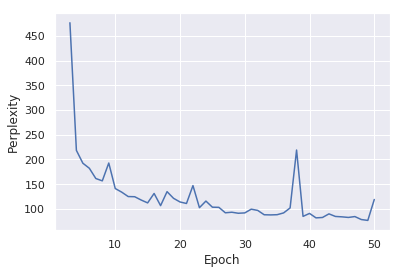

In [22]:
plt.plot(list(range(3,51)),perp_list[2:])
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.show()